In [143]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import f1_score
from functools import partial



<h3>Prepare Datasets</h3>

In [3]:
train_dataset = pd.read_csv('Datasets/train_dataset.csv')
test_dataset = pd.read_csv('Datasets/test_dataset.csv')

train_pca_dataset = pd.read_csv('Datasets/PCA_train_data.csv')
test_pca_dataset = pd.read_csv('Datasets/PCA_test_data.csv')

train_tree_dataset = pd.read_csv('Datasets/Tree_train_data.csv')
test_tree_dataset = pd.read_csv('Datasets/Tree_test_data.csv')


X_train = train_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_train = train_dataset['attack_category']

X_test = test_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_test = test_dataset['attack_category']

from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

X_pca_train = train_pca_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_pca_train = train_pca_dataset['attack_category']

X_pca_test = test_pca_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_pca_test = test_pca_dataset['attack_category']

X_tree_train = train_tree_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_tree_train = train_tree_dataset['attack_category']

X_tree_test = test_tree_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_tree_test = test_tree_dataset['attack_category']

In [4]:
def train_model(model, X, y):
    skf = StratifiedKFold(n_splits=5)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, average='weighted')
        recall = recall_score(y_test, pred, average='weighted') 
        f1 = f1_score(y_test, pred, average='weighted') 

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # print('{0} Accuracy: {1: .5f} Precision: {2: .5f} Recall: {3: .5f} F1_Score: {4: .5f}'.format(
    #     model.__class__.__name__, 
    #     np.mean(accuracy_scores),
    #     np.mean(precision_scores),
    #     np.mean(recall_scores),
    #     np.mean(f1_scores)))
    
    return -np.mean(f1_scores)

In [5]:
def evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Model: ", model.__class__.__name__)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("####################################")
    
    # report = classification_report(y_test, y_pred)
    # print("Classification Report:\n", report)
    
    return -f1

<h3> Model for Neural Network without PCA or Tree </h3>

In [151]:
num_classes = 5
tf.random.set_seed(42)
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])


In [152]:
def f1_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    f1_partial = partial(f1_score, average='macro')
    f1 = tf.py_function(f1_partial, (y_true, y_pred_labels), tf.float32)
    return f1

# Compile the model with Adam optimizer and F1 metric
nn_model.compile(optimizer=Adam(learning_rate=0.002),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[f1_metric])


In [153]:
nn_model.summary()

Model: "sequential_244"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1221 (Dense)          (None, 64)                2944      
                                                                 
 dropout_977 (Dropout)       (None, 64)                0         
                                                                 
 dense_1222 (Dense)          (None, 128)               8320      
                                                                 
 dropout_978 (Dropout)       (None, 128)               0         
                                                                 
 dense_1223 (Dense)          (None, 512)               66048     
                                                                 
 dropout_979 (Dropout)       (None, 512)               0         
                                                                 
 dense_1224 (Dense)          (None, 128)            

In [154]:
nn_history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 45s 11ms/step - loss: 0.1718 - f1_metric: 0.8936 - val_loss: 1.3917 - val_f1_metric: 0.5858
Epoch 2/10
3937/3937 [==============================] - 47s 12ms/step - loss: 0.1144 - f1_metric: 0.9173 - val_loss: 1.5624 - val_f1_metric: 0.5443
Epoch 3/10
3937/3937 [==============================] - 39s 10ms/step - loss: 0.1120 - f1_metric: 0.9224 - val_loss: 1.8762 - val_f1_metric: 0.5649
Epoch 4/10
3937/3937 [==============================] - 41s 10ms/step - loss: 0.1105 - f1_metric: 0.9231 - val_loss: 1.8183 - val_f1_metric: 0.5694
Epoch 5/10
3937/3937 [==============================] - 42s 11ms/step - loss: 0.1085 - f1_metric: 0.9258 - val_loss: 1.3724 - val_f1_metric: 0.5856
Epoch 6/10
3937/3937 [==============================] - 55s 14ms/step - loss: 0.1087 - f1_metric: 0.9272 - val_loss: 1.7705 - val_f1_metric: 0.5600
Epoch 7/10
3937/3937 [==============================] - 50s 13ms/step - loss: 0.1080 - f1_metric: 0.9238 - val_l

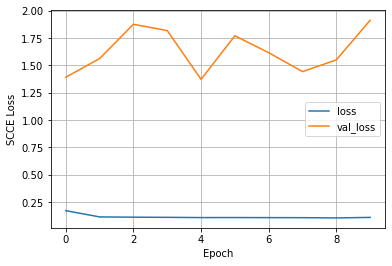

In [157]:
plt.plot(nn_history.history['loss'], label='loss')
plt.plot(nn_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

In [156]:
plt.plot(nn_history.history['accuracy'], label='accuracy')
plt.plot(nn_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

KeyError: 'accuracy'

In [158]:
y_pred_probs = nn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy for no PCA and no tree:", accuracy)
print("Precision for no PCA and no tree:", precision)
print("Recall for no PCA and no tree:", recall)
print("F1 Score for no PCA and no tree:", f1)

705/705 [==============================] - 2s 3ms/step
Accuracy for no PCA and no tree: 0.7505322924059616
Precision for no PCA and no tree: 0.7865329164713438
Recall for no PCA and no tree: 0.7505322924059616
F1 Score for no PCA and no tree: 0.7006338381787869


<h3> Neural networks with PCA </h3>

In [145]:
tf.random.set_seed(42)
nn_model_pca = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_pca_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])

In [146]:
# Define F1 metric with tf.py_function
def f1_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    f1_partial = partial(f1_score, average='macro')
    f1 = tf.py_function(f1_partial, (y_true, y_pred_labels), tf.float32)
    return f1

# Compile the model with Adam optimizer and F1 metric
nn_model_pca.compile(optimizer=Adam(learning_rate=0.002),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[f1_metric])


In [147]:
nn_history_pca = nn_model_pca.fit(X_pca_train, y_pca_train, validation_data=(X_pca_test, y_pca_test), epochs=8, verbose=1)

Epoch 1/8
3937/3937 [==============================] - 89s 22ms/step - loss: 0.1934 - f1_metric: 0.8841 - val_loss: 1.3657 - val_f1_metric: 0.5374
Epoch 2/8
3937/3937 [==============================] - 101s 26ms/step - loss: 0.1380 - f1_metric: 0.8991 - val_loss: 1.3204 - val_f1_metric: 0.5620
Epoch 3/8
3937/3937 [==============================] - 66s 17ms/step - loss: 0.1360 - f1_metric: 0.9044 - val_loss: 1.8412 - val_f1_metric: 0.5721
Epoch 4/8
3937/3937 [==============================] - 68s 17ms/step - loss: 0.1328 - f1_metric: 0.9046 - val_loss: 1.4043 - val_f1_metric: 0.5764
Epoch 5/8
3937/3937 [==============================] - 65s 16ms/step - loss: 0.1305 - f1_metric: 0.9046 - val_loss: 1.1722 - val_f1_metric: 0.6490
Epoch 6/8
3937/3937 [==============================] - 62s 16ms/step - loss: 0.1325 - f1_metric: 0.9067 - val_loss: 1.7667 - val_f1_metric: 0.5568
Epoch 7/8
3937/3937 [==============================] - 162s 41ms/step - loss: 0.1332 - f1_metric: 0.9050 - val_loss: 

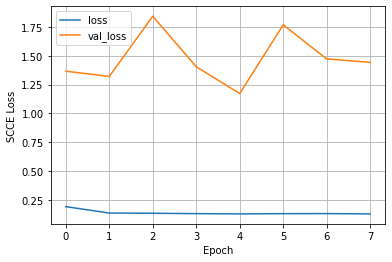

In [148]:
plt.plot(nn_history_pca.history['loss'], label='loss')
plt.plot(nn_history_pca.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

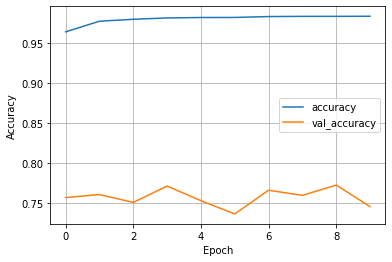

In [149]:
plt.plot(nn_history.history['accuracy'], label='accuracy')
plt.plot(nn_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [150]:
y_pred_probs_pca = nn_model_pca.predict(X_pca_test)
y_pred_pca = np.argmax(y_pred_probs_pca, axis=-1)


accuracy_pca = accuracy_score(y_pca_test, y_pred_pca)
precision_pca = precision_score(y_pca_test, y_pred_pca, average='weighted')
recall_pca = recall_score(y_pca_test, y_pred_pca, average='weighted')
f1_pca = f1_score(y_pca_test, y_pred_pca, average='weighted')

# Print the metrics
print("Accuracy for PCA:", accuracy_pca)
print("Precision for PCA:", precision_pca)
print("Recall for PCA:", recall_pca)
print("F1 Score for PCA:", f1_pca)

705/705 [==============================] - 2s 2ms/step
Accuracy for PCA: 0.7558108587650816
Precision for PCA: 0.6894021104134364
Recall for PCA: 0.7558108587650816
F1 Score for PCA: 0.7060163716460938


<h3> Neural networks for tree </h3>

In [139]:
nn_model_tree = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_tree_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])

In [140]:
# Define F1 metric with tf.py_function
def f1_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    f1_partial = partial(f1_score, average='macro')
    f1 = tf.py_function(f1_partial, (y_true, y_pred_labels), tf.float32)
    return f1

# Compile the model with Adam optimizer and F1 metric
nn_model_tree.compile(optimizer=Adam(learning_rate=0.002),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[f1_metric])



In [141]:
nn_history_tree = nn_model_tree.fit(X_tree_train, y_tree_train, validation_data=(X_tree_test, y_tree_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 146s 36ms/step - loss: 0.1707 - f1_metric: 0.8937 - val_loss: 1.3332 - val_f1_metric: 0.5781
Epoch 2/10
3937/3937 [==============================] - 138s 35ms/step - loss: 0.1143 - f1_metric: 0.9168 - val_loss: 1.2621 - val_f1_metric: 0.5832
Epoch 3/10
3937/3937 [==============================] - 154s 39ms/step - loss: 0.1106 - f1_metric: 0.9218 - val_loss: 1.9036 - val_f1_metric: 0.5716
Epoch 4/10
3937/3937 [==============================] - 145s 37ms/step - loss: 0.1089 - f1_metric: 0.9249 - val_loss: 1.4526 - val_f1_metric: 0.5939
Epoch 5/10
3937/3937 [==============================] - 137s 35ms/step - loss: 0.1080 - f1_metric: 0.9239 - val_loss: 1.2329 - val_f1_metric: 0.6122
Epoch 6/10
3937/3937 [==============================] - 147s 37ms/step - loss: 0.1087 - f1_metric: 0.9253 - val_loss: 1.8519 - val_f1_metric: 0.5562
Epoch 7/10
3937/3937 [==============================] - 115s 29ms/step - loss: 0.1064 - f1_metric: 0.9234 

In [142]:
y_pred_probs_tree = nn_model_tree.predict(X_tree_test)
y_pred_tree = np.argmax(y_pred_probs_tree, axis=-1)


accuracy_tree = accuracy_score(y_tree_test, y_pred_tree)
precision_tree = precision_score(y_tree_test, y_pred_tree, average='weighted')
recall_tree = recall_score(y_tree_test, y_pred_tree, average='weighted')
f1_tree= f1_score(y_tree_test, y_pred_tree, average='weighted')

# Print the metrics
print("Accuracy for tree:", accuracy_tree)
print("Precision for tree:", precision_tree)
print("Recall for tree:", recall_tree)
print("F1 Score for tree:", f1_tree)

705/705 [==============================] - 4s 6ms/step
Accuracy for PCA: 0.7711586231369766
Precision for PCA: 0.813364071890421
Recall for PCA: 0.7711586231369766
F1 Score for PCA: 0.7359452531851266
